# ML Assignment on Perinatal Risk Information Collection Data Set

Importing all the important libraries used

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
# importing the dataset using pandas
df = pd.read_csv('Perinatal Risk Information-1.csv')
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Type
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


We see that Type is string type column with string values and remaining are numeric type columns. This gives intution that our 'Type' column could be a target or dependent variable with categories. Let's explore it and get insights

In [6]:
for name in df['Type'].unique():
    print(name)

high risk
low risk
mid risk


As we see in the above dataset structure the Dependent variable or the Targeet variable is **Type** column which has labels as **High Risk**, **Low Risk**, **Mid Risk**

In [9]:
#checking for any data imbalance based on the classes 
df['Type'].value_counts()

Type
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

In [11]:
#checking for the proportion (percentage)
df['Type'].value_counts()/len(df)

Type
low risk     0.400394
mid risk     0.331361
high risk    0.268245
Name: count, dtype: float64

We get an idea that our overall distribution of low risk, mid risk and high risk are kind similar, so no case of any imbalance

In [14]:
# Removing the column Type as its Dependent variable
X = df.drop(columns = ['Type'], axis = 0, inplace = False)
y = df['Type']
X.shape, y.shape

((1014, 6), (1014,))

In [16]:
#Checking for any na or missing values in any of the columns
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
Type           0
dtype: int64

since there are no missing values, hence we wouldn't require to do any missing data handling

In [19]:
# getting summary of the dataset
X.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


We can see the whole range of the data present in each columns. We see that the min value of HeartRate is 7, which definetly cannot be possible and could be a human error or device/sensor error, so we will try to get rid of it

In [22]:
#shape of df
X.shape

(1014, 6)

In [24]:
# have consider the min heart rate as 30 based on the information from internet that athletes have recorded heartRate at range of 30-40 (min) (Domain Knowledge)
X[X['HeartRate']< 30]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
499,16,120,75,7.9,98.0,7
908,16,120,75,7.9,98.0,7


lets remove the above columns as it can hamper the accuracy of our model

In [27]:
# removing those indices from y (target variable)
indices = X[X['HeartRate']<30].index
y = y.drop(indices)
y.shape

(1012,)

In [29]:
# removing the rows from the which has heart rate less than 30
X = X[X['HeartRate'] > 30]
X.shape

(1012, 6)

Checknig for other outliers which we couldn't notice from the summary above

<Axes: >

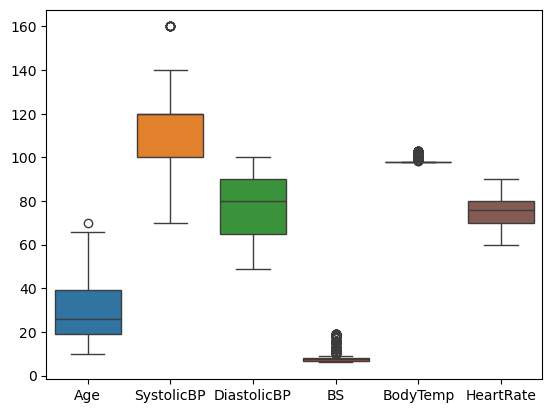

In [32]:
sns.boxplot(X)

We see a lot of outliers in the above dataset, lets get a count of overall no. of rows for which atleast one column is having an ourtlier

In [35]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
iqr = Q3-Q1
lower_bound = Q1 - iqr*1.5 # formula to calculate lower_bound
upper_bound = Q3 + iqr*1.5 # formula to calculate upper_bound
outliers_df = X[((X < lower_bound) | (X > upper_bound)).any(axis = 1)]
outliers_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
7,35,85,60,11.0,102.0,86
9,42,130,80,18.0,98.0,70
...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80
1010,55,120,90,18.0,98.0,60
1011,35,85,60,19.0,98.0,86
1012,43,120,90,18.0,98.0,70


In [37]:
len(outliers_df)/len(X)

0.38735177865612647

Since there a considerable amount of outliers in the dataset we can't just remove it otherwise we lose a significant amount of information. To remove any of them, further domain knowledge exploration would be required

<Axes: >

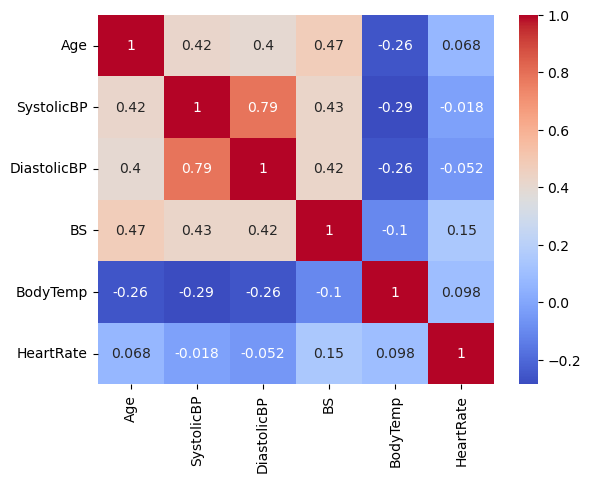

In [40]:
# Checking for any correlations among the features
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

We see that there is high correlation among the columns SystolicBP and DiastolicBP

### Spliting dataset into training and test set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 6), (203, 6), (809,), (203,))

Checkin the data imbalance in train and test datasets accordingly

In [46]:
y_train.value_counts()/len(y_train)

Type
low risk     0.405439
mid risk     0.337454
high risk    0.257108
Name: count, dtype: float64

In [48]:
y_test.value_counts()/len(y_test)

Type
low risk     0.374384
high risk    0.315271
mid risk     0.310345
Name: count, dtype: float64

We don't find any imbalance even after our train test split, therefore we can consider train and test dataset as a good representation of each other.

We don't require to do any scalling in this as we are going to use Decision Tree and Random Forest for our classification problem. These models are invariant to any scaling. Feature scaling is only useful in those algorithms which are distance based. We will see an example below

In [52]:
standScale= StandardScaler()

In [54]:
X_train_std = standScale.fit_transform(X_train)
X_test_std = standScale.transform(X_test)

# Implementing the Decision tree and Random Forest algorithm and check which one is more accurate

In [57]:
# Normal (No Hyperparameter tuning)
decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, criterion= 'gini')

model = decision_tree.fit(X_train_std, y_train)
print("Model Training Score: ", model.score(X_train_std, y_train))
print("Model Testing Score: ", model.score(X_test_std, y_test))

Model Training Score:  0.7070457354758962
Model Testing Score:  0.7438423645320197


In [59]:
# Decison Tree Hyperparameter tuning
decision_tree = DecisionTreeClassifier()


param_grid = {'max_depth': [5,10,20, None],
             'min_samples_split': [2,5,10],
             'min_samples_leaf':[1,2,5],
             'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(estimator = decision_tree, param_grid= param_grid, cv = 5, n_jobs= 1, verbose= 1)
grid_search.fit(X_train_std, y_train)

print("Best parameter from decision tree: ", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameter from decision tree:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [61]:
# best classifier
best_tree = grid_search.best_estimator_

print("Model Training Score: ",best_tree.score(X_train_std, y_train))
print("Model Testing Score: ", best_tree.score(X_test_std, y_test))

Model Training Score:  0.9258343634116193
Model Testing Score:  0.8522167487684729


lets check what if we skip the feature scaling, how would be the performance of the model

In [64]:
# Decison Tree Hyperparameter tuning
decision_tree = DecisionTreeClassifier()


param_grid = {'max_depth': [5,10,20, None],
             'min_samples_split': [2,5,10],
             'min_samples_leaf':[1,2,5],
             'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(estimator = decision_tree, param_grid= param_grid, cv = 5, n_jobs= 1, verbose= 1)
grid_search.fit(X_train, y_train)

print("Best parameter from decision tree: ", grid_search.best_params_)

# best classifier
best_tree_test = grid_search.best_estimator_

print("Model Training Score: ",best_tree_test.score(X_train, y_train))
print("Model Testing Score: ", best_tree_test.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameter from decision tree:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model Training Score:  0.9258343634116193
Model Testing Score:  0.8472906403940886


There is no significant difference in the accuracies whether if we perform feature scaling or not on our dataset

In [67]:
# Normal Random Forest (No Hyperparameter tuning)
rf = RandomForestClassifier(n_estimators = 500, max_depth = 20, min_samples_split= 5, min_samples_leaf=2, bootstrap= True)

model_rf = rf.fit(X_train_std, y_train)
print("Model Training Score: ", model_rf.score(X_train_std, y_train))
print("Model Testing Score: ", model_rf.score(X_test_std, y_test))

Model Training Score:  0.9048207663782447
Model Testing Score:  0.812807881773399


In [68]:
# Random Forest Hyperparameter tuning
rf = RandomForestClassifier()

param_grid_rf = {'n_estimators': [100, 200, 500],
                'max_depth': [10,20,30,None],
                'min_samples_split': [2,5,10],
                'min_samples_leaf':[1,2,4]}
grid_search_rf = GridSearchCV(estimator= rf, param_grid= param_grid_rf, cv = 5, n_jobs = -1, verbose = 1)

grid_search_rf.fit(X_train_std, y_train)

print("Best parameter from Random forest: ",grid_search_rf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameter from Random forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [70]:
# best classifier Random Forest
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train_std,y_train)
print("Model Training Score: ", best_rf.score(X_train_std, y_train))
print("Model Testing Score: ", best_rf.score(X_test_std, y_test))

Model Training Score:  0.9258343634116193
Model Testing Score:  0.8472906403940886


lets check the model performance if we hadn't did any feature scaling similar to what we did for Random Forest

In [83]:
# Random Forest Hyperparameter tuning
rf = RandomForestClassifier()

param_grid_rf = {'n_estimators': [100, 200, 500],
                'max_depth': [10,20,30,None],
                'min_samples_split': [2,5,10],
                'min_samples_leaf':[1,2,4]}
grid_search_rf = GridSearchCV(estimator= rf, param_grid= param_grid_rf, cv = 5, n_jobs = -1, verbose = 1)

grid_search_rf.fit(X_train, y_train)

print("Best parameter from Random forest: ",grid_search_rf.best_params_)

# best classifier Random Forest
best_rf_test = grid_search_rf.best_estimator_
best_rf_test.fit(X_train,y_train)
print("Model Training Score: ", best_rf_test.score(X_train, y_train))
print("Model Testing Score: ", best_rf_test.score(X_test, y_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameter from Random forest:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Training Score:  0.9258343634116193
Model Testing Score:  0.8472906403940886


# Calculating the accuracy, classification Report and graphical comparision

In [85]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#decison tree
preds = best_tree_test.predict(X_test)
print("Model Accuracy score: ", accuracy_score(y_test, y_pred= preds))
print(classification_report(y_test, y_pred= preds))

Model Accuracy score:  0.8472906403940886
              precision    recall  f1-score   support

   high risk       0.89      0.91      0.90        64
    low risk       0.89      0.83      0.86        76
    mid risk       0.76      0.81      0.78        63

    accuracy                           0.85       203
   macro avg       0.85      0.85      0.85       203
weighted avg       0.85      0.85      0.85       203



In [87]:
#Random Forest
preds = best_rf_test.predict(X_test)
print("Model Accuracy score: ", accuracy_score(y_test, y_pred= preds))
print(classification_report(y_test, y_pred= preds))

Model Accuracy score:  0.8472906403940886
              precision    recall  f1-score   support

   high risk       0.91      0.91      0.91        64
    low risk       0.86      0.86      0.86        76
    mid risk       0.78      0.78      0.78        63

    accuracy                           0.85       203
   macro avg       0.85      0.85      0.85       203
weighted avg       0.85      0.85      0.85       203



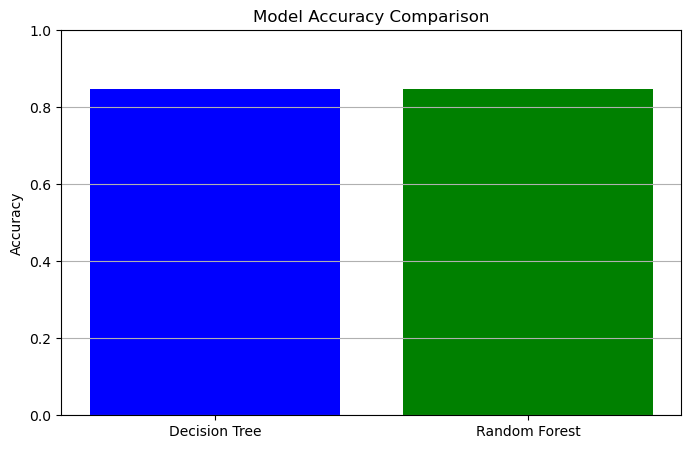

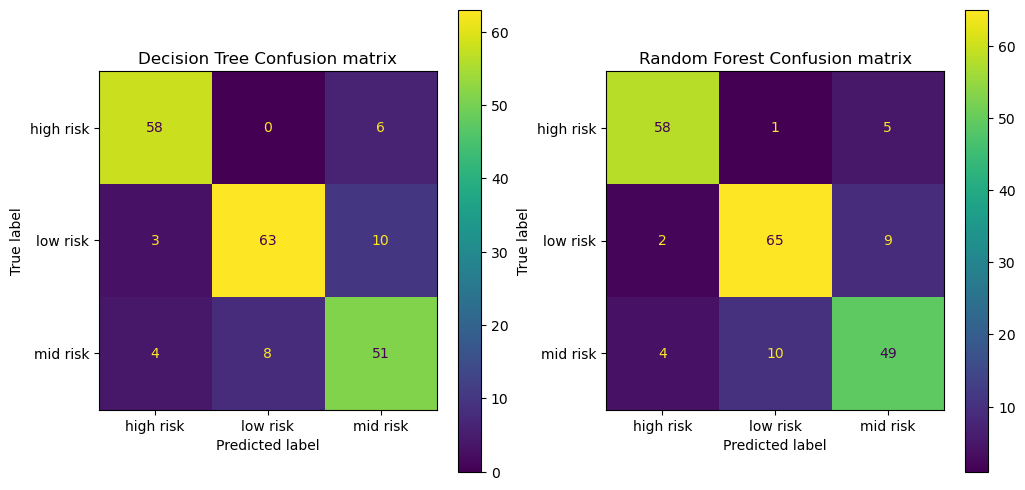

In [89]:
models = ['Decision Tree', 'Random Forest']
y_pred_tree = best_tree_test.predict(X_test)
y_pred_rf = best_rf_test.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred= y_pred_tree)
accuracy_rf = accuracy_score(y_test, y_pred= y_pred_rf)
accuracies = [accuracy_dt, accuracy_rf]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.show()

# Confusion Matrix Visualization
conf_matrix_dt = confusion_matrix(y_test, y_pred = y_pred_tree)
conf_matrix_rf = confusion_matrix(y_test, y_pred = y_pred_rf)

fig, axes = plt.subplots(1,2, figsize = (12,6))
ConfusionMatrixDisplay(conf_matrix_dt, display_labels= best_tree_test.classes_).plot(ax = axes[0])
axes[0].set_title("Decision Tree Confusion matrix")
ConfusionMatrixDisplay(conf_matrix_rf, display_labels= best_rf_test.classes_).plot(ax = axes[1])
axes[1].set_title("Random Forest Confusion matrix")
plt.show()


If we check the above graphs for the comparision between the two models, the accuracy of both the models look almost similar